<a href="https://colab.research.google.com/github/Smarth2005/A4-Learning-PDF-using-data/blob/main/GAN%20Assignment%20Solution-102497023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Advance Mathematics- Assignment-2: Learning Probability Density Function using GAN

In [ ]:
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# University Roll Number
r = 102497023

# Calculating constants
a = 0.05*(r % 7)
b = 0.3 *(r % 5 +1)

print(f"Constants for roll number {r}:\na = {a:.4f}\nb = {b:.4f}")

Constants for roll number 102497023:
a = 0.3000
b = 1.2000


In [ ]:
# Install dependencies as needed:
!pip install kagglehub[pandas-datasets]

In [ ]:
# Read the dataset into a DataFrame and extract feature NO2 into x
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "data.csv"

# Load the latest version
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "shrutibhargava94/india-air-quality-data",
  file_path,
  pandas_kwargs={"encoding": "cp1252"}
)

print(df.shape)
df.head()

/tmp/ipython-input-948783711.py:8: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'india-air-quality-data' dataset.
(435742, 13)


/usr/local/lib/python3.12/dist-packages/kagglehub/pandas_datasets.py:91: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  result = read_function(


,stn_code,sampling_date,state,location,agency,type,so2,no2,rspm,spm,location_monitoring_station,pm2_5,date
0,150.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",4.8,17.4,NaN,NaN,NaN,NaN,1990-02-01
1,151.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,3.1,7.0,NaN,NaN,NaN,NaN,1990-02-01
2,152.0,February - M021990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.2,28.5,NaN,NaN,NaN,NaN,1990-02-01
3,150.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,"Residential, Rural and other Areas",6.3,14.7,NaN,NaN,NaN,NaN,1990-03-01
4,151.0,March - M031990,Andhra Pradesh,Hyderabad,NaN,Industrial Area,4.7,7.5,NaN,NaN,NaN,NaN,1990-03-01


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 435742 entries, 0 to 435741
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   stn_code                     291665 non-null  object 
 1   sampling_date                435739 non-null  object 
 2   state                        435742 non-null  object 
 3   location                     435739 non-null  object 
 4   agency                       286261 non-null  object 
 5   type                         430349 non-null  object 
 6   so2                          401096 non-null  float64
 7   no2                          419509 non-null  float64
 8   rspm                         395520 non-null  float64
 9   spm                          198355 non-null  float64
 10  location_monitoring_station  408251 non-null  object 
 11  pm2_5                        9314 non-null    float64
 12  date                         435735 non-null  object 
dtyp

In [ ]:
x  = df['no2'].dropna().values
x = x.astype(np.float32)

print("Total NO2 samples:", len(x))
print("Min:", x.min(), "Max:", x.max())

Total NO2 samples: 419509
Min: 0.0 Max: 876.0


In [ ]:
# Data transformation
z = x + a * np.sin(b*x)

print("Transformed z stats:")
print("Min:", z.min(), "Max:", z.max())

Transformed z stats:
Min: 0.0 Max: 876.2831


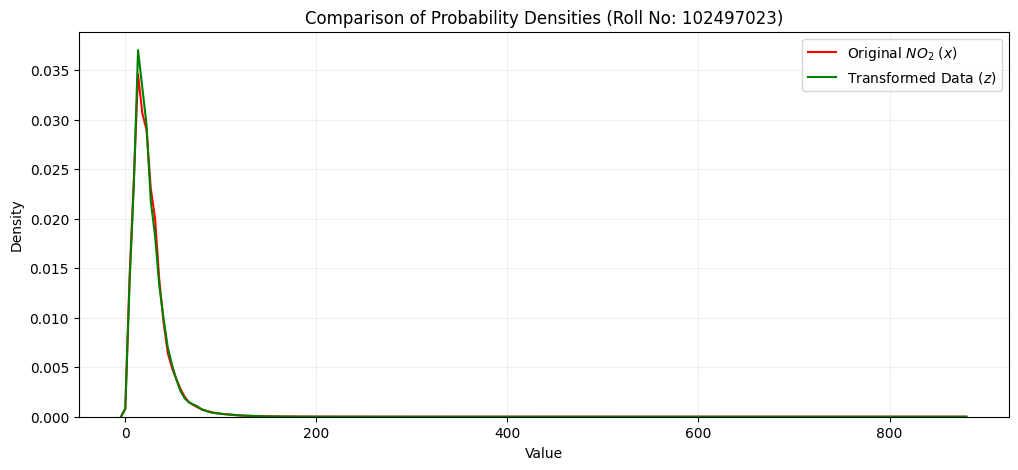

In [ ]:
# Visualizing the Density Curve
plt.figure(figsize=(12,5))

# Plot Density of Original Data (x)
sns.kdeplot(x, color='red', label='Original $NO_2$ ($x$)', fill=False)

# Plot Density of Transformed Data (z)
sns.kdeplot(z, color='green', label='Transformed Data ($z$)', fill=False)

# Add labels and styling
plt.title(f'Comparison of Probability Densities (Roll No: {r})')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.grid(True, alpha=0.2)
plt.show()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

latent_dim = 10

Using device: cuda


In [ ]:
# GAN Architecture
class Generator(nn.Module):
  def __init__(self, latent_dim):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(latent_dim, 64),
        nn.ReLU(),
        nn.Linear(64, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 1)
    )

  def forward(self, x):
    return self.model(x)


class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = nn.Sequential(
        nn.Linear(1, 64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, 128),
        nn.LeakyReLU(0.2),
        nn.Linear(128, 64),
        nn.LeakyReLU(0.2),
        nn.Linear(64, 1),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.model(x)

In [ ]:
type(z)

numpy.ndarray

In [ ]:
# Sampling
max_samples = 50000

if len(z) > max_samples:
    idx = np.random.choice(len(z), max_samples, replace=False)
    z = z[idx]

print("Samples used for training:", len(z))

Samples used for training: 50000


In [ ]:
# Convert numpy array to pytorch tensor
z_tensor = torch.tensor(z).view(-1,1)
dataset  = TensorDataset(z_tensor)

# Prepare DataLoader
batch_size = 512
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
# GAN Initialization and Setup
netG = Generator(latent_dim).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()

lr = 0.0002
optG = optim.Adam(netG.parameters(), lr=lr, betas=(0.5, 0.999))
optD = optim.Adam(netD.parameters(), lr=lr, betas=(0.5, 0.999))

epochs = 1000
lossesG = []
lossesD = []

In [ ]:
# Training loop
for epoch in range(epochs):
    for real_batch in dataloader:
        real_samples = real_batch[0].to(device)

        # Labels
        real_labels = torch.ones(real_samples.size(0), 1).to(device)
        fake_labels = torch.zeros(real_samples.size(0), 1).to(device)

        # Train Discriminator
        optD.zero_grad()

        output_real = netD(real_samples)
        loss_real = criterion(output_real, real_labels)

        noise = torch.randn(real_samples.size(0), latent_dim).to(device)
        fake_samples = netG(noise)

        output_fake = netD(fake_samples.detach())
        loss_fake = criterion(output_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        optD.step()

        # Train Generator
        optG.zero_grad()

        noise = torch.randn(real_samples.size(0), latent_dim).to(device)
        fake_samples = netG(noise)

        output_fakeG = netD(fake_samples)
        loss_G = criterion(output_fakeG, real_labels)

        loss_G.backward()
        optG.step()

    lossesD.append(loss_D.item())
    lossesG.append(loss_G.item())

    if (epoch+1) % 50 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] | Loss D: {loss_D.item():.4f} | Loss G: {loss_G.item():.4f}")


Epoch [50/1000] | Loss D: 1.3795 | Loss G: 0.6664
Epoch [100/1000] | Loss D: 1.3849 | Loss G: 0.7229
Epoch [150/1000] | Loss D: 1.3813 | Loss G: 0.7164
Epoch [200/1000] | Loss D: 1.3756 | Loss G: 0.6683
Epoch [250/1000] | Loss D: 1.3883 | Loss G: 0.7941
Epoch [300/1000] | Loss D: 1.3758 | Loss G: 0.7316
Epoch [350/1000] | Loss D: 1.3758 | Loss G: 0.6665
Epoch [400/1000] | Loss D: 1.3828 | Loss G: 0.6448
Epoch [450/1000] | Loss D: 1.3747 | Loss G: 0.7269
Epoch [500/1000] | Loss D: 1.3823 | Loss G: 0.7413
Epoch [550/1000] | Loss D: 1.3744 | Loss G: 0.7020
Epoch [600/1000] | Loss D: 1.3717 | Loss G: 0.7026
Epoch [650/1000] | Loss D: 1.3767 | Loss G: 0.6956
Epoch [700/1000] | Loss D: 1.3834 | Loss G: 0.7107
Epoch [750/1000] | Loss D: 1.3826 | Loss G: 0.7021
Epoch [800/1000] | Loss D: 1.3872 | Loss G: 0.7340
Epoch [850/1000] | Loss D: 1.3807 | Loss G: 0.6942
Epoch [900/1000] | Loss D: 1.3831 | Loss G: 0.6654
Epoch [950/1000] | Loss D: 1.3848 | Loss G: 0.7182
Epoch [1000/1000] | Loss D: 1.39

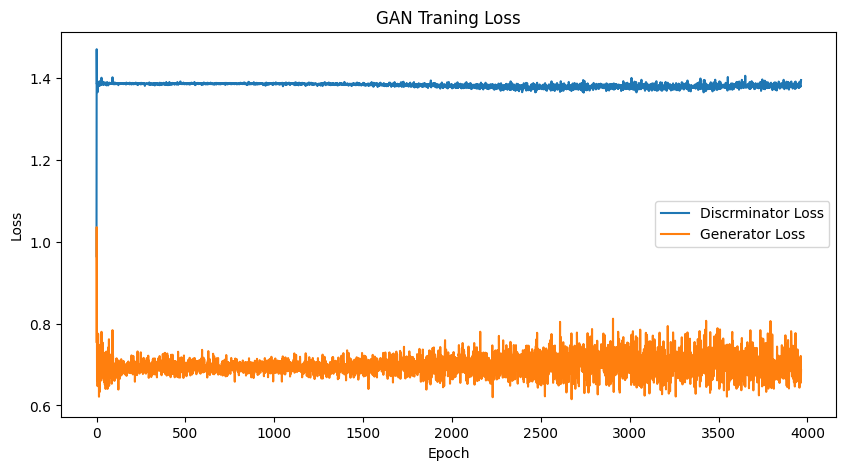

In [ ]:
# plot training loss graph
plt.figure(figsize=(10,5))
plt.plot(lossesD, label="Discrminator Loss")
plt.plot(lossesG, label="Generator Loss")
plt.title("GAN Traning Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
# Generate samples from Generator
num_samples = 5000
noise = torch.randn(num_samples, latent_dim).to(device)

with torch.no_grad():
  generated_samples = netG(noise).cpu().numpy().flatten()

print("Generated samples: ", generated_samples.shape)

Generated samples:  (5000,)


In [ ]:
# Estimate PDF using KDE
kde_real = gaussian_kde(z)
kde_fake = gaussian_kde(generated_samples)

x_grid = np.linspace(min(z.min(), generated_samples.min()),
                     max(z.max(), generated_samples.max()),
                     1000)

pdf_real = kde_real(x_grid)
pdf_fake = kde_fake(x_grid)

In [ ]:
from scipy.stats import entropy

kl_div = entropy(pdf_real, pdf_fake)
print(f"KL Divergence: {kl_div:.4f}")

M = 0.5 * (pdf_real + pdf_fake)
js_div = 0.5 * entropy(pdf_real, M) + 0.5 * entropy(pdf_fake, M)
print(f"JS Divergence: {js_div:.4f}")

KL Divergence: inf
JS Divergence: 0.0010


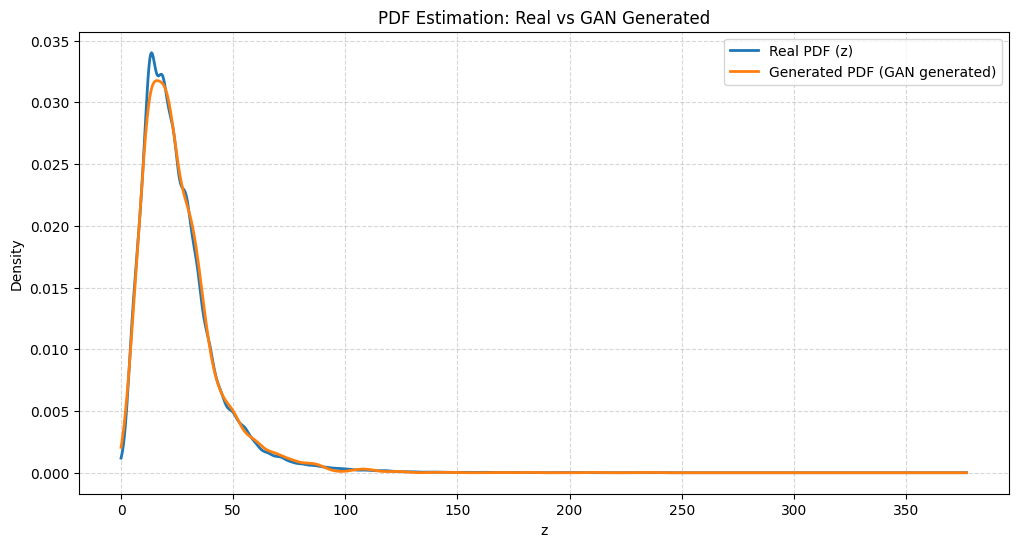

In [ ]:
# Plot real PDF vs. GAN PDF
plt.figure(figsize=(12,6))
plt.plot(x_grid, pdf_real, label="Real PDF (z)", linewidth=2)
plt.plot(x_grid, pdf_fake, label="Generated PDF (GAN generated)", linewidth=2)

plt.title("PDF Estimation: Real vs GAN Generated")
plt.xlabel("z")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()